In [1]:
# general tools
import os
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

In [2]:
from datetime import datetime, timedelta

In [3]:
import re

In [4]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.keras import utils
from tensorflow.keras import Model

tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2023-02-10 11:02:04.762647: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [5]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
#import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [7]:
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    
def create_model(input_shape=(64, 64, 15)):

    depths=[3, 3, 27, 3]
    projection_dims=[32, 64, 96, 128]
    drop_path_rate=0.0
    layer_scale_init_value=1e-6


    model_name='Branch64X'
    IN64 = layers.Input(shape=input_shape)
    X = IN64
    # ----- convnext block 0 ----- #

    X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

    for j in range(depths[0]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                                   groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext


    # ----- convnext block 1 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

    for j in range(depths[1]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                                   groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext

    # ----- convnext block 2 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

    for j in range(depths[2]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=5, padding="same",
                                   groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext

    # ----- convnext block 3 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X)

    for j in range(depths[3]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=5, padding="same",
                                   groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext

    V1 = X

    OUT = layers.GlobalMaxPooling2D(name="{}_head_pool64".format(model_name))(V1)
#     OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm64".format(model_name))(OUT)

#     OUT = layers.Dense(64, name="{}_dense1".format(model_name))(OUT)
#     OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT)
#     OUT = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT)

#     OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

    model = Model(inputs=IN64, outputs=OUT, name=model_name)
    
    return model


In [8]:
def create_model_head():

    
    IN_vec = keras.Input((128,))    
    X = IN_vec
    #
    X = keras.layers.Dense(64)(X)
    X = keras.layers.Activation("relu")(X)
    X = keras.layers.BatchNormalization()(X)
    
    OUT = X
    OUT = keras.layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(-10))(OUT)

    model = keras.models.Model(inputs=IN_vec, outputs=OUT)
    
    return model

In [9]:
def verif_metric(VALID_target, Y_pred):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{}'.format(BS))
    metric = BS

    return metric

In [10]:
#ind_pick_from_batch = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]
ind_pick_from_batch = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
L_vars = len(ind_pick_from_batch)

In [11]:
vers = ['v3', 'v4x', 'v4']
leads = [2, 3, 4, 5, 6, 20, 21, 22, 23]
filenames_pos = {}
filenames_neg = {}

for ver in vers:
    for lead in leads:
        if ver == 'v3' and lead < 23:
            path_ = '/glade/scratch/ksha/DATA/NCAR_batch_v3/'
        elif ver == 'v3' and lead == 23:
            path_ = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/'
        elif ver == 'v4':
            path_ = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v4/'
        else:
            path_ = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v4x/'
            
        filenames_pos['{}_lead{}'.format(ver, lead)] = sorted(glob("{}*pos*lead{}.npy".format(path_, lead)))
        filenames_neg['{}_lead{}'.format(ver, lead)] = sorted(glob("{}*neg_neg_neg*lead{}.npy".format(path_, lead)))
        
        print('{}, lead{}, pos: {}, neg: {}'.format(ver, lead, 
                                                    len(filenames_pos['{}_lead{}'.format(ver, lead)]), 
                                                    len(filenames_neg['{}_lead{}'.format(ver, lead)])))



v3, lead2, pos: 5510, neg: 887822
v3, lead3, pos: 4297, neg: 889035
v3, lead4, pos: 3242, neg: 890090
v3, lead5, pos: 2565, neg: 891795
v3, lead6, pos: 2127, neg: 891205
v3, lead20, pos: 5407, neg: 887925
v3, lead21, pos: 6711, neg: 887649
v3, lead22, pos: 7613, neg: 886747
v3, lead23, pos: 8009, neg: 886351
v4x, lead2, pos: 1995, neg: 348553
v4x, lead3, pos: 1618, neg: 349958
v4x, lead4, pos: 1218, neg: 350358
v4x, lead5, pos: 962, neg: 350614
v4x, lead6, pos: 817, neg: 349731
v4x, lead20, pos: 1777, neg: 344659
v4x, lead21, pos: 2209, neg: 344227
v4x, lead22, pos: 2511, neg: 343925
v4x, lead23, pos: 2690, neg: 343746
v4, lead2, pos: 2174, neg: 402858
v4, lead3, pos: 1724, neg: 403308
v4, lead4, pos: 1349, neg: 403683
v4, lead5, pos: 1034, neg: 403998
v4, lead6, pos: 795, neg: 403209
v4, lead20, pos: 0, neg: 0
v4, lead21, pos: 0, neg: 0
v4, lead22, pos: 0, neg: 0
v4, lead23, pos: 0, neg: 0


In [12]:
def name_extract(filenames):
    
    date_base = datetime(2020, 7, 14)
    date_base2 = datetime(2021, 1, 1)
    
    filename_train = []
    filename_valid = []
    
    base_v3_s = datetime(2018, 7, 15)
    base_v3_e = datetime(2020, 12, 2)

    base_v4_s = datetime(2020, 12, 3)
    base_v4_e = datetime(2022, 7, 15)

    base_ref = datetime(2010, 1, 1)
    
    date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
    date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+365+30)]
    
    base_ref = datetime(2019, 10, 1)
    date_list_v4x = [base_ref + timedelta(days=day) for day in range(429)]
    
    for i, name in enumerate(filenames):
        
        if 'v4x' in name:
            date_list = date_list_v4x
        elif 'v4' in name:
            date_list = date_list_v4
        else:
            date_list = date_list_v3
        
        nums = re.findall(r'\d+', name)
        day = int(nums[-4])
        day = date_list[day]
        
        if (day - date_base).days < 0:
            filename_train.append(name)
            
        else:
            if (day - date_base2).days < 0:
                filename_valid.append(name)

        
    return filename_train, filename_valid

In [13]:
filenames_pos_train = {}
filenames_neg_train = {}

filenames_pos_valid = {}
filenames_neg_valid = {}

for ver in vers:
    for lead in leads:
        temp_namelist_pos = filenames_pos['{}_lead{}'.format(ver, lead)]
        temp_namelist_neg = filenames_neg['{}_lead{}'.format(ver, lead)]
        
        pos_train, pos_valid = name_extract(temp_namelist_pos)
        neg_train, neg_valid = name_extract(temp_namelist_neg)
        
        print('pos train: {} pos valid: {} neg train: {} neg valid {}'.format(len(pos_train), 
                                                                              len(pos_valid), 
                                                                              len(neg_train), 
                                                                              len(neg_valid)))
        
        filenames_pos_train['{}_lead{}'.format(ver, lead)] = pos_train
        filenames_neg_train['{}_lead{}'.format(ver, lead)] = neg_train
        
        filenames_pos_valid['{}_lead{}'.format(ver, lead)] = pos_valid
        filenames_neg_valid['{}_lead{}'.format(ver, lead)] = neg_valid

pos train: 4856 pos valid: 654 neg train: 742500 neg valid 145322
pos train: 3787 pos valid: 510 neg train: 743569 neg valid 145466
pos train: 2874 pos valid: 368 neg train: 744482 neg valid 145608
pos train: 2289 pos valid: 276 neg train: 746095 neg valid 145700
pos train: 1885 pos valid: 242 neg train: 745471 neg valid 145734
pos train: 4632 pos valid: 775 neg train: 742724 neg valid 145201
pos train: 5774 pos valid: 937 neg train: 742610 neg valid 145039
pos train: 6589 pos valid: 1024 neg train: 741795 neg valid 144952
pos train: 6952 pos valid: 1057 neg train: 741432 neg valid 144919
pos train: 1452 pos valid: 543 neg train: 225736 neg valid 122817
pos train: 1187 pos valid: 431 neg train: 226001 neg valid 123957
pos train: 898 pos valid: 320 neg train: 226290 neg valid 124068
pos train: 721 pos valid: 241 neg train: 226467 neg valid 124147
pos train: 598 pos valid: 219 neg train: 225562 neg valid 124169
pos train: 1136 pos valid: 641 neg train: 220912 neg valid 123747
pos train: 

In [14]:
pos_train_all = []
neg_train_all = []
pos_valid_all = []
neg_valid_all = []

for ver in vers:
    for lead in leads:
        pos_train_all += filenames_pos_train['{}_lead{}'.format(ver, lead)]
        neg_train_all += filenames_neg_train['{}_lead{}'.format(ver, lead)]
        pos_valid_all += filenames_pos_valid['{}_lead{}'.format(ver, lead)]
        neg_valid_all += filenames_neg_valid['{}_lead{}'.format(ver, lead)]

In [15]:
# filename_valid = neg_valid_all[::200] + pos_valid_all[::20]
# print(len(filename_valid))

# L_valid = len(filename_valid)

# VALID_input_64 = np.empty((L_valid, 64, 64, L_vars))
# VALID_target = np.ones(L_valid)

# for i, name in enumerate(filename_valid):
#     data = np.load(name)
#     for k, c in enumerate(ind_pick_from_batch):
        
#         VALID_input_64[i, ..., k] = data[..., c]

#         if 'pos' in name:
#             VALID_target[i] = 1.0
#         else:
#             VALID_target[i] = 0.0
            
# save_dir = '/glade/work/ksha/NCAR/'
# tuple_save = (VALID_input_64, VALID_target)
# label_save = ['VALID_input_64', 'VALID_target']
# du.save_hdf5(tuple_save, label_save, save_dir, 'CNN_Validation.hdf')

In [18]:
# save_dir = '/glade/work/ksha/NCAR/'
# tuple_save = (VALID_input_64, VALID_target)
# label_save = ['VALID_input_64', 'VALID_target']
# du.save_hdf5(tuple_save, label_save, save_dir, 'CNN_Validation.hdf')

Save to /glade/work/ksha/NCAR/CNN_Validation.hdf


In [16]:
save_dir = '/glade/work/ksha/NCAR/'

with h5py.File(save_dir+'CNN_Validation.hdf', 'r') as h5io:
    VALID_input_64 = h5io['VALID_input_64'][...]
    VALID_target = h5io['VALID_target'][...]

In [17]:
flag_train = 'base'

if flag_train == 'head':
    flag_weights = 'base'
else:
    flag_weights = 'head'
    
weights_round = 4
save_round = 5

In [18]:
model_head = create_model_head()

# W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/HY_Lead4/')
# model_head.set_weights(W_old)

model_base = create_model(input_shape=(64, 64, 15))

# W_new = model_base.get_weights()
# W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE2_peak_{}{}/'.format(flag_weights, weights_round))

# for i in range(len(W_new)):
#     if W_new[i].shape == W_old[i].shape:
#         W_new[i] = W_old[i]
#     else:
#         ewraewthws
        
# model_base.set_weights(W_new)

# if flag_train == 'base':
#     for layer in model_head.layers: 
#         layer.trainable = False
# elif flag_train == 'head':
#     for layer in model_base.layers: 
#         layer.trainable = False

2023-02-10 11:11:03.485167: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-10 11:11:03.488413: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-10 11:11:03.552373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:8a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-10 11:11:03.552409: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-10 11:11:03.625762: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-10 11:11:03.625802: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [19]:
IN = layers.Input(shape=(64, 64, 15))

VEC = model_base(IN)
OUT = model_head(VEC)

model_final = Model(inputs=IN, outputs=OUT)

In [21]:

weights_round = 6
W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE2_peak_base{}/'.format(weights_round))
model_final.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(lr=1e-4))
model_final.set_weights(W_old)

OSError: SavedModel file does not exist at: /glade/work/ksha/NCAR/Keras_models/RE2_peak_base6//{saved_model.pbtxt|saved_model.pb}

In [ ]:
# if flag_train == 'base':
#     for layer in model_head.layers: 
#         layer.trainable = False
# elif flag_train == 'head':
#     for layer in model_base.layers: 
#         layer.trainable = False

In [ ]:
# Y_pred = model_final.predict([VALID_input_64])
# record_temp = verif_metric(VALID_target, Y_pred)
# 0.025381361192679055 0.025381361192679055

In [ ]:
Y_pred = model_final.predict([VALID_input_64])
record_temp = verif_metric(VALID_target, Y_pred)

In [ ]:
0.023387565552267165

In [ ]:
weights_round = 5
W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE2_peak_base{}/'.format(weights_round))
model_final.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(lr=1e-4))
model_final.set_weights(W_old)

In [ ]:
Y_pred = model_final.predict([VALID_input_64])
record_temp = verif_metric(VALID_target, Y_pred)

In [26]:
# W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE1_15p_base/')
# model_final.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(lr=1e-4))
# model_final.set_weights(W_old)

# Y_pred = model_final.predict([VALID_input_64])
# record_temp = verif_metric(VALID_target, Y_pred)

In [27]:
# W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE1_15p_full/')
# model_final.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(lr=1e-4))
# model_final.set_weights(W_old)

# Y_pred = model_final.predict([VALID_input_64])
# record_temp = verif_metric(VALID_target, Y_pred)

#0.03020596704790702

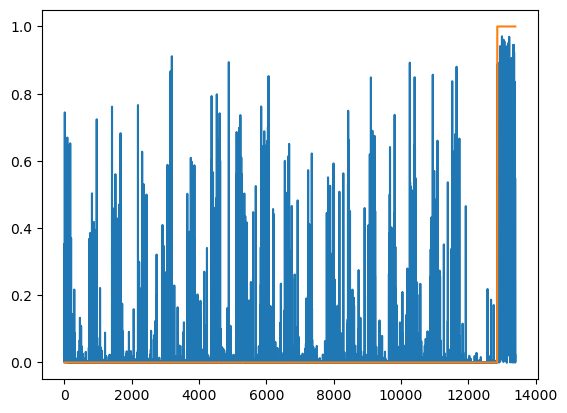

In [28]:
plt.plot(Y_pred)
plt.plot(VALID_target)

In [29]:
seeds = 1567 #3725 #

min_del = 0
max_tol = 100 # early stopping with patience

epochs = 500
batch_size = 200
L_train = 64 #int(len(TRAIN_Y_pick) / batch_size)

X_batch_64 = np.empty((batch_size, 64, 64, L_vars))
Y_batch = np.empty((batch_size, 1))

X_batch_64[...] = np.nan
Y_batch[...] = np.nan

temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

# =========== Model Section ========== #
key = 'RE2_peak_{}{}'.format(flag_train, save_round)
model_name = '{}'.format(key)
model_path = temp_dir+model_name

tol = 0

filename_pos_train = pos_train_all
filename_neg_train = neg_train_all
# ========== Training loop ========== #
L_pos = len(filename_pos_train)
L_neg = len(filename_neg_train)

record = record_temp #0.01840167896363949 #record_temp
print("Initial record: {}".format(record))

set_seeds(seeds)
    
for i in range(epochs):
    start_time = time.time()

    # loop of batch
    for j in range(L_train):
        if flag_train == 'base':
            N_pos = 20
        else:
            N_pos = 20
            
        N_neg = batch_size - N_pos

        ind_neg = du.shuffle_ind(L_neg)
        ind_pos = du.shuffle_ind(L_pos)

        file_pick_neg = []
        for ind_temp in ind_neg[:N_neg]:
            file_pick_neg.append(filename_neg_train[ind_temp])

        file_pick_pos = []
        for ind_temp in ind_pos[:N_pos]:
            file_pick_pos.append(filename_pos_train[ind_temp])

        file_pick = file_pick_neg + file_pick_pos

        if len(file_pick) != batch_size:
            sregwet

        for k in range(batch_size):
            data = np.load(file_pick[k])

            for l, c in enumerate(ind_pick_from_batch):
                temp = data[..., c] 
                X_batch_64[k, ..., l] = temp

            if 'pos' in file_pick[k]:
                Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
            else:
                werhgaer

        ind_ = du.shuffle_ind(batch_size)
        X_batch_64 = X_batch_64[ind_, ...]
        Y_batch = Y_batch[ind_, :]

        # train on batch
        model_final.train_on_batch(X_batch_64, Y_batch);

    # epoch end operations
    Y_pred = model_final.predict([VALID_input_64])
    # Y_pred[Y_pred<0] = 0
    # Y_pred[Y_pred>1] = 1

    record_temp = verif_metric(VALID_target, Y_pred)

    # if i % 10 == 0:
    #     model.save(model_path_backup)

    if (record - record_temp > min_del):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model_final.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        if record_temp >= 2.0:
            print('Early stopping')
            break;
        else:
            tol += 1
            if tol >= max_tol:
                print('Early stopping')
                break;
            else:
                continue;
    print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 0.023829177376227677
0.024499779667834818
Validation loss 0.024499779667834818 NOT improved



KeyboardInterrupt



In [ ]:
plt.plot(Y_pred)